✔ Dataset Loaded Successfully!

   duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0  0.666287       0.577740  0.248644  0.039280   0.151331   0.441503   
1  0.143014       0.729235  0.539983  0.485997   0.055436   0.291892   
2  0.401813       0.101389  0.961499  0.367041   0.133935   0.567280   
3  0.887278       0.168009  0.660708  0.656651   0.614879   0.400250   
4  0.360109       0.274258  0.064115  0.353499   0.531030   0.539846   

       land  wrong_fragment    urgent       hot  ...  dst_host_srv_count  \
0  0.996257        0.739421  0.042406  0.244036  ...            0.223672   
1  0.143944        0.858332  0.304242  0.901082  ...            0.610218   
2  0.080431        0.875795  0.603445  0.235740  ...            0.077247   
3  0.853977        0.907267  0.469452  0.998242  ...            0.054651   
4  0.001381        0.897988  0.350272  0.597418  ...            0.118315   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                0.336817

<Figure size 1000x600 with 0 Axes>

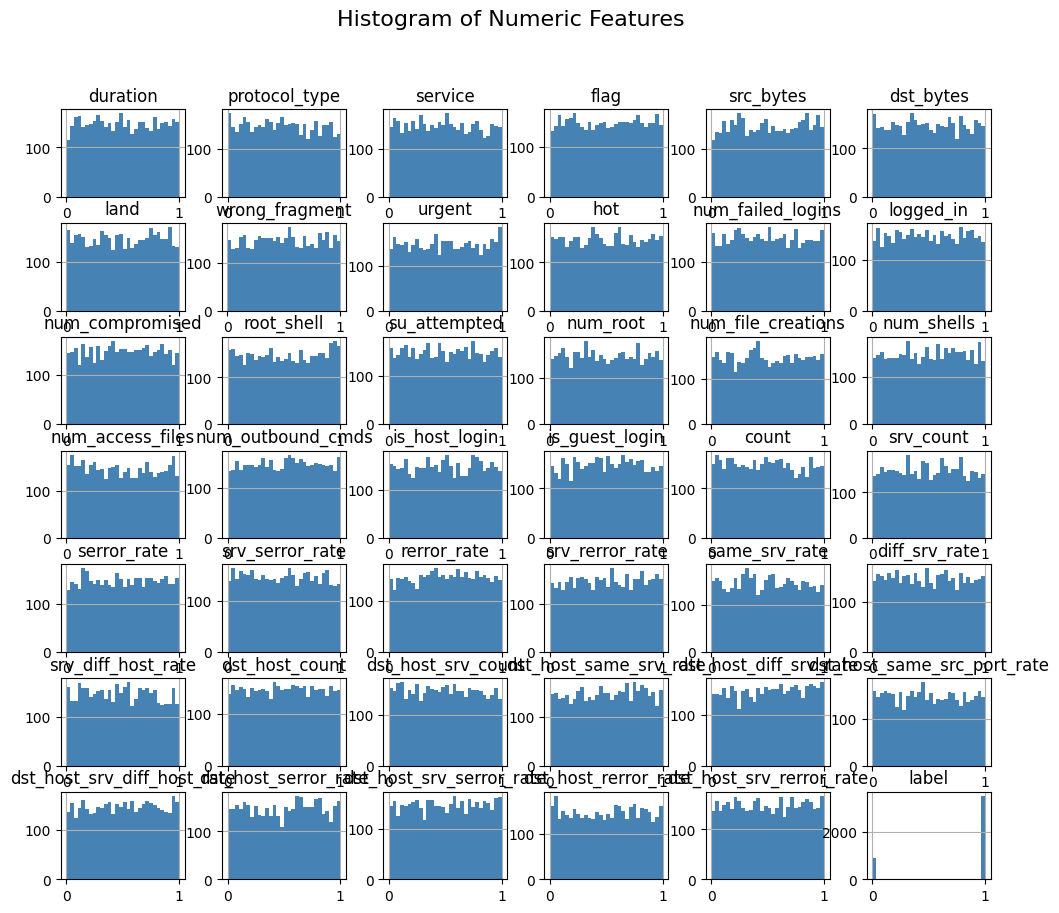

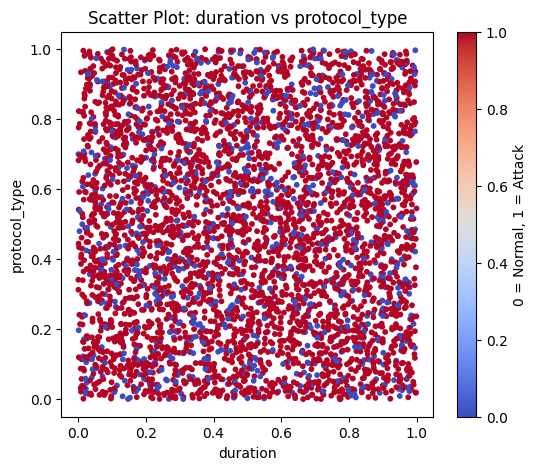


 TRAINING MODEL: Logistic Regression

✔ Results for Logistic Regression:
Accuracy : 0.8024830699774267
Precision: 0.8024830699774267
Recall   : 1.0
ROC-AUC  : 0.49840466144263607


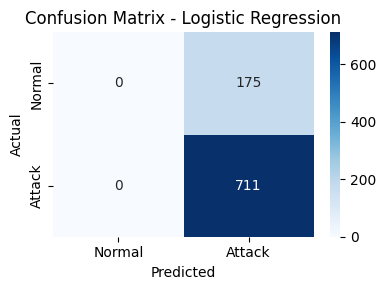


 TRAINING MODEL: Decision Tree

✔ Results for Decision Tree:
Accuracy : 0.664785553047404
Precision: 0.8044117647058824
Recall   : 0.7693389592123769
ROC-AUC  : 0.5046694796061885


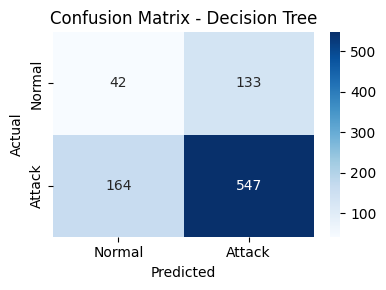


 TRAINING MODEL: Random Forest

✔ Results for Random Forest:
Accuracy : 0.8024830699774267
Precision: 0.8024830699774267
Recall   : 1.0
ROC-AUC  : 0.5033674904560981


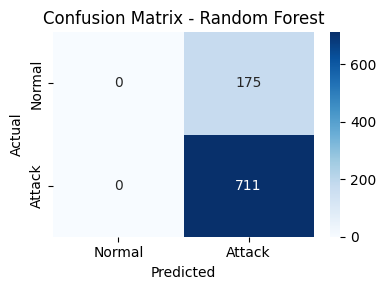

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# =============================================================
# 1. LOAD NSL-KDD DATASET
# =============================================================
df = pd.read_csv("/content/nsl_kdd_dataset.csv")

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

# Convert labels → attack = 1, normal = 0
df["label"] = df["label"].apply(lambda x: 0 if x == "normal" else 1)

# =============================================================
# EXTRA: HISTOGRAM & SCATTER PLOTS
# =============================================================

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# -------- HISTOGRAM --------
plt.figure(figsize=(10,6))
df[numeric_cols].hist(figsize=(12,10), bins=30, color='steelblue')
plt.suptitle("Histogram of Numeric Features", fontsize=16)
plt.show()

# -------- SCATTER PLOT --------
# Pick two numeric features automatically
if len(numeric_cols) >= 2:
    plt.figure(figsize=(6,5))
    plt.scatter(df[numeric_cols[0]], df[numeric_cols[1]],
                c=df["label"], cmap="coolwarm", s=10)
    plt.xlabel(numeric_cols[0])
    plt.ylabel(numeric_cols[1])
    plt.title(f"Scatter Plot: {numeric_cols[0]} vs {numeric_cols[1]}")
    plt.colorbar(label="0 = Normal, 1 = Attack")
    plt.show()


# =============================================================
# 2. FEATURE & LABEL SPLIT
# =============================================================
X = df.drop("label", axis=1)
y = df["label"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# =============================================================
# 3. PREPROCESS PIPELINE
# =============================================================
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# =============================================================
# 4. VALID MODELS (NO LINEAR REGRESSION)
# =============================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200)
}

# =============================================================
# 5. TRAIN-TEST SPLIT
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================================================
# 6. TRAIN & EVALUATE EACH MODEL
# =============================================================
for name, algo in models.items():
    print("\n========================================")
    print(f" TRAINING MODEL: {name}")
    print("========================================")

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("classifier", algo)
    ])

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n✔ Results for {name}:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

    # ------------ CONFUSION MATRIX ------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Attack"],
                yticklabels=["Normal","Attack"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# END